# Project WebScrapping
# IronHack - Data Analyst

# Objective:

### Scrap the website  [`Metacritcs`](https://www.metacritic.com)  and store informartion about games.


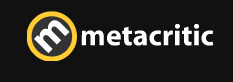

# Selected plataforms:

### -Playstation 4 
### -Xbox One 
### -Switch  

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from itertools import chain
import re

# Defining class Meta_scrap

In [ ]:
class Meta_scrap:
    '''
    Class to define url's of the metacritic that will be scrapped
    
    plataf_url > string or list[string]
    '''        
    def __init__(self,plataf_url,
                 root_url='https://www.metacritic.com',
                 headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}):
        
        self.root_url = root_url
        
        self.plataf_url = plataf_url
        
        self.headers = headers
        
    def page_range(self):
        '''
        Receive an url and create a list of the url page of 0 to 99.
        
        Original URL:
        
        https://www.metacritic.com/search/game/results?search_type=advanced&plats[268409]=

        Result:
        
        https://www.metacritic.com/search/game/results?search_type=advanced&plats[268409]=0
        https://www.metacritic.com/search/game/results?search_type=advanced&plats[268409]=1
        https://www.metacritic.com/search/game/results?search_type=advanced&plats[268409]=2
        '''
        
        all_urls = [url + str(i) for i in range(100) for url in self.plataf_url]
        
        return all_urls
 
    def find_game_tag(self,page):
        '''
        Find the game all game tags in a page and return in form of list.
        '''
         
        response = requests.get(url=page,headers=self.headers)
        
        soup = BeautifulSoup(response.content)
        
        games_urls = []
        
        for tag in soup.find_all(name='h3', attrs={'class':'product_title basic_stat'}):
            games_urls.append(self.root_url + tag.a['href'] + '/details')
        
        return games_urls
    
    def games_url(self):
        
        '''
        Apply function find_game_tag to all pages obtained through page_range
        '''
        
        all_urls = Meta_scrap.page_range(self)
        
        all_games_urls = [self.find_game_tag(page) for page in all_urls]
        
        all_games_urls = list(chain.from_iterable(all_games_urls))
        
        return all_games_urls
             
    def game_info(self,game_page):
        
        '''
        Return an dict of information of the game
        '''
        try:
            
            response = requests.get(url=game_page,headers=self.headers)

            soup = BeautifulSoup(response.content)
            name = soup.find(name='div', attrs={'class':'product_title'}).a.text.strip()

            rel_date = soup.find(name='li', attrs={'class':'summary_detail release_data'}).text[15:].strip()
            rel_date = str(pd.to_datetime(rel_date))[:10]

            metascore = soup.find_all(name='a', attrs={'class':'metascore_anchor'})[0].span.text
            metascore = int(metascore)

            n_crit_rev = soup.find(name='div', attrs={'class':'summary'}).a.text.strip()
            n_crit_rev = int(re.sub('\D','',n_crit_rev))         

            user_score = soup.find_all(name='a', attrs={'class':'metascore_anchor'})[1].div.text
            user_score = float(user_score)         

            n_usr_rev = soup.find_all(name='div', attrs={'class':'summary'})[1].a.text
            n_usr_rev = int(re.sub('\D','',n_usr_rev))

            plataform = soup.find(name='span', attrs={'class':'platform'}).text.strip()

            rating = soup.find(name='tr', attrs={'class':'alt'}).text[9]

            developer = soup.find_all(name='tr')[2].td.text.strip()
            developer = re.sub('\s+',' ',developer).split(',')                

            mul_player = soup.find_all(name='tr')[4].td.text
            mul_player = bool(re.match('\d',mul_player))

            url = game_page

            game_info = {'name':name,'plataform':plataform,'rel_date':rel_date,'metascore':metascore,
                         'n_crit_revies':n_crit_rev,'userscore':user_score,'n_usr_rev':n_usr_rev,
                         'rating':rating,'developer':developer,'mul_player':mul_player,'url':url}
        
            return game_info
    
        except:
            
            pass        
    
    def scrap(self):
        '''
        Execute the whole scrap process in the selected palataforms pages
        '''
        
        all_games_urls = Meta_scrap.games_url(self)
        
        df_games = pd.DataFrame(columns=['name',     
                                         'plataform',
                                         'rel_date',
                                         'metascore',
                                         'n_crit_revies',
                                         'userscore',
                                         'n_usr_rev',
                                         'rating',
                                         'developer',
                                         'mul_player',
                                         'url'])
        
        for gameurl in all_games_urls:
            
            data = self.game_info(gameurl)
                        
            df_games = df_games.append(data, ignore_index=True)

        return df_games

# Defining URL's

In [ ]:
ps4 = ['https://www.metacritic.com/search/game/results?plats%5B72496%5D=1&search_type=advanced&page=']

xone = ['https://www.metacritic.com/search/game/results?search_type=advanced&plats[80000]=']

switch = ['https://www.metacritic.com/search/game/results?search_type=advanced&plats[268409]=']

all_plat = ['https://www.metacritic.com/search/game/results?plats%5B72496%5D=1&search_type=advanced&page=',
            'https://www.metacritic.com/search/game/results?search_type=advanced&plats[268409]=',
            'https://www.metacritic.com/search/game/results?search_type=advanced&plats[268409]=']

# Scraping PS4

In [ ]:
meta_scrap_ps4 = Meta_scrap(ps4)

In [ ]:
%%time

df_ps4 = meta_scrap_ps4.scrap()

In [ ]:
df_ps4.to_json(path_or_buf='ps4_json.txt',orient='columns')

# Scraping Xone

In [ ]:
meta_scrap_xone = Meta_scrap(xone)

In [ ]:
%%time

df_xone = meta_scrap_xone.scrap()

# Scraping Switch

In [ ]:
meta_scrap_switch = Meta_scrap(switch)

In [ ]:
%%time

df_switch = meta_scrap_switch.scrap()

# Concatening dataframe's

In [ ]:
df_games = pd.concat([df_ps4,df_switch,df_xone],ignore_index=True)

# Generating json file

In [ ]:
df_ps4.to_json(path_or_buf='ps4_json.txt',orient='columns')
df_switch.to_json(path_or_buf='switch_json.txt',orient='columns')
df_xone.to_json(path_or_buf='xone_json.txt',orient='columns')
df_games.to_json(path_or_buf='games_json.txt',orient='columns')